# Fastscapelib "user flow kernels" prototype

In [1]:
import numba as nb
from numba.experimental import jitclass

In [2]:
from textwrap import dedent, indent

import numpy as np

import numba as nb
from testpy import Kernel


spec = [
    ("drainage_area", nb.float64[::1]),
    ("elevation", nb.float64[::1]),
    ("erosion", nb.float64[::1]),
    ("distance", nb.float64[::1]),
    ("weight", nb.float64[::1]),
    ("_drainage_area", nb.float64[::1]),
    ("_elevation", nb.float64[::1]),
    ("_erosion", nb.float64[::1]),
    ("_distance", nb.float64[::1]),
    ("_weight", nb.float64[::1]),
    ("_max_count", nb.int64),
    ("count", nb.uint64),
]


@nb.experimental.jitclass(spec)
class ReceiversData(object):
    def __init__(self):
        pass


class NumbaFlowKernel:
    def __init__(
        self,
        flow_graph,
        kernel_func,
        grid_data,
        constants,
        outputs=(),
        max_receivers=-1,
    ):
        self.flow_graph = flow_graph
        self.outputs = outputs
        self.max_receivers = max_receivers
        self.grid_data_keys = list(grid_data.keys())

        self.kernel = kernel = Kernel()

        self._flow_kernel = nb.njit(inline="always")(kernel_func)
        self.data, self.node_data = self._build_kernel_data_classes(
            grid_data, constants, max_receivers
        )

        self._set_kernel_ptr()
        self._set_node_data_getter(max_receivers)
        self._set_node_data_setter()

        from numba.experimental.jitclass import _box

        kernel.data.meminfo = _box.box_get_meminfoptr(self.data)
        kernel.data.data = _box.box_get_dataptr(self.data)

        kernel.node_data.meminfo = _box.box_get_meminfoptr(self.node_data)
        kernel.node_data.data = _box.box_get_dataptr(self.node_data)

    def _set_kernel_ptr(self):
        jitted_fun = self._flow_kernel.get_compile_result(
            nb.core.typing.Signature(
                nb.none,
                (nb.typeof(self.node_data), nb.float64),
                None,
            )
        )

        self.kernel.func = jitted_fun.library.get_pointer_to_function(
            jitted_fun.fndesc.llvm_cfunc_wrapper_name
        )

    def _set_node_data_getter(self, max_receivers):
        self.node_data_getter = func = self._build_node_data_getter(max_receivers)
        jitted_fun = func.get_compile_result(
            nb.core.typing.Signature(
                nb.none,
                (nb.uint64, nb.typeof(self.data), nb.typeof(self.node_data)),
                None,
            )
        )

        self.kernel.node_data_getter = jitted_fun.library.get_pointer_to_function(
            jitted_fun.fndesc.llvm_cfunc_wrapper_name
        )

    def _set_node_data_setter(self):
        self.node_data_setter = func = self._build_node_data_setter()
        jitted_fun = func.get_compile_result(
            nb.core.typing.Signature(
                nb.none,
                (nb.uint64, nb.typeof(self.node_data), nb.typeof(self.data)),
                None,
            )
        )

        self.kernel.node_data_setter = jitted_fun.library.get_pointer_to_function(
            jitted_fun.fndesc.llvm_cfunc_wrapper_name
        )

    def _set_node_data_init(self, cls, func):
        jitted_fun = func.get_compile_result(
            nb.core.typing.Signature(
                cls.class_type.instance_type,
                (),
                None,
            )
        )

        self.kernel.node_data_init = jitted_fun.library.get_pointer_to_function(
            jitted_fun.fndesc.llvm_cfunc_wrapper_name
        )

    def _build_kernel_data_classes(self, grid_data, constants, max_receivers):
        """Builds kernel data classes from a flow graph and user provided data."""
        flow_graph = self.flow_graph

        for name, value in grid_data.items():
            if value.size != flow_graph.size:
                raise ValueError("Invalid size")
            if value.shape != (flow_graph.size,):
                raise ValueError("Invalid shape")

        EroderNodeData = self._build_node_data_jitclass(
            grid_data, constants, max_receivers
        )
        EroderData = self._build_data_jitclass(grid_data)

        flow_graph_data = {
            "donors_idx": flow_graph.impl().donors.view(),
            "donors_count": flow_graph.impl().donors_count.view(),
            "receivers_idx": flow_graph.impl().receivers.view(),
            "receivers_count": flow_graph.impl().receivers_count.view(),
            "receivers_distance": flow_graph.impl().receivers_distance.view(),
            "receivers_weight": flow_graph.impl().receivers_weight.view(),
        }
        data = EroderData(**grid_data, **flow_graph_data)
        node_data = EroderNodeData()

        @nb.njit
        def node_data_init():
            return EroderNodeData()

        self._set_node_data_init(EroderNodeData, node_data_init)

        return data, node_data

    @staticmethod
    def _generate_jitclass(name, spec, init_source, glbls={}):
        exec(init_source, glbls)
        ctor = glbls["generated_init"]
        return nb.experimental.jitclass(spec)(type(name, (), {"__init__": ctor}))

    def _build_node_data_jitclass(self, grid_data, constants, max_receivers):
        base_spec = [("receivers", ReceiversData.class_type.instance_type)]
        grid_data_spec = [(name, nb.float64) for name in grid_data]
        constants_spec = [(name, nb.typeof(value)) for name, value in constants.items()]

        __init___template = dedent(
            """
        def generated_init(self):
            {constants_content}

            self.receivers = ReceiversData()
            self.receivers._distance = np.ones({default_size})
            self.receivers._weight = np.ones({default_size})
            {receivers_content_init}

            self.receivers.distance = self.receivers._distance[:]
            self.receivers.weight = self.receivers._weight[:]
            {receivers_content_view}

            self.receivers._max_count = {max_receivers}
            self.receivers.count = 0
        """
        )

        default_size = max_receivers if max_receivers > 0 else 0
        constants_content = "\n    ".join(
            [f"self.{name} = {value}" for name, value in constants.items()]
        )
        receivers_content_init = "\n    ".join(
            [
                f"self.receivers._{name} = np.ones({default_size})"
                for name, _ in grid_data.items()
            ]
        )
        receivers_content_view = "\n    ".join(
            [
                f"self.receivers.{name} = self.receivers._{name}[:]"
                for name, _ in grid_data.items()
            ]
        )
        init_source = __init___template.format(
            constants_content=constants_content,
            receivers_content_init=receivers_content_init,
            receivers_content_view=receivers_content_view,
            default_size=default_size,
            max_receivers=max_receivers,
        )

        return NumbaFlowKernel._generate_jitclass(
            "FlowKernelNodeData",
            base_spec + grid_data_spec + constants_spec,
            init_source,
            {"ReceiversData": ReceiversData, "np": np},
        )

    def _build_data_jitclass(self, grid_data):
        base_spec = [
            ("donors_idx", nb.uint64[:, ::1]),
            ("donors_count", nb.uint64[::1]),
            ("receivers_idx", nb.uint64[:, ::1]),
            ("receivers_count", nb.uint64[::1]),
            ("receivers_distance", nb.float64[:, ::1]),
            ("receivers_weight", nb.float64[:, ::1]),
        ]
        grid_data_spec = [(name, nb.typeof(value)) for name, value in grid_data.items()]
        spec = base_spec + grid_data_spec

        __init___template = dedent(
            """
        def generated_init(self, {args}):
            {content}
        """
        )

        content = "\n    ".join([f"self.{name} = {name}" for name, _ in spec])
        args = ", ".join([name for name, _ in spec])
        init_source = __init___template.format(content=content, args=args)

        return NumbaFlowKernel._generate_jitclass(
            "FlowKernelData",
            spec,
            init_source,
        )

    node_data_getter_tmpl = dedent(
        """
        def node_data_getter(index, data, node_data):
            receivers_count = data.receivers_count[index]
            receivers = node_data.receivers

        {node_content}
            {resize_content}

            receivers.count = receivers_count

            for i in range(receivers_count):
                receiver_idx = data.receivers_idx[index, i]
                receivers._distance[i] = data.receivers_distance[index, i]
                receivers._weight[i] = data.receivers_weight[index, i]
        {receivers_set_content}

            return 0
        """
    )

    node_data_getter_fixed_resize_tmpl = dedent(
        """
        if receivers._max_count < receivers_count:
            return 1
            
        if receivers_count != receivers.count:
            set_view(
                (
    {receivers_view_content},
                    (receivers.distance, receivers._distance),
                    (receivers.weight, receivers._weight),
                ),
                receivers_count,
            )"""
    )

    node_data_getter_dynamic_resize_tmpl = dedent(
        """ 
        if receivers_count != receivers.count:
            if receivers_count > receivers.count:
                resize(
                (
    {receivers_resize_content},
                    receivers._distance,
                    receivers._weight,
                ),
                receivers_count,
            )

            set_view(
                (
    {receivers_view_content},
                    (receivers.distance, receivers._distance),
                    (receivers.weight, receivers._weight),
                ),
                receivers_count,
            )"""
    )

    def _build_node_data_getter(self, max_receivers):

        node_content = "\n".join(
            [f"node_data.{name} = data.{name}[index]" for name in self.grid_data_keys]
        )
        receivers_view_content = f",\n".join(
            [f"(receivers.{name}, receivers._{name})" for name in self.grid_data_keys]
        )
        receivers_resize_content = f",\n".join(
            [f"receivers._{name}" for name in self.grid_data_keys]
        )
        receivers_set_content = "\n".join(
            [
                f"receivers._{name}[i] = data.{name}[receiver_idx]"
                for name in self.grid_data_keys
            ]
        )

        if max_receivers > 0:
            resize_tmpl = self.node_data_getter_fixed_resize_tmpl
        else:
            resize_tmpl = self.node_data_getter_dynamic_resize_tmpl

        getter_source = self.node_data_getter_tmpl.format(
            node_content=indent(node_content, " " * 4),
            resize_content=resize_tmpl,
            receivers_set_content=indent(receivers_set_content, " " * 8),
        ).format(
            receivers_view_content=indent(receivers_view_content, " " * 16),
            receivers_resize_content=indent(receivers_resize_content, " " * 16),
        )

        @nb.njit(inline="always")
        def set_view(data, size):
            for view, source in data:
                view = source[:size]

        @nb.njit(inline="always")
        def resize(data, size):
            for arr in data:
                arr = np.empty(size)

        glbls = {"set_view": set_view, "resize": resize}
        exec(getter_source, glbls)
        getter_fun = glbls["node_data_getter"]

        return nb.njit(inline="always", boundscheck=False)(getter_fun)

    node_data_setter_tmpl = dedent(
        """
        def node_data_setter(index, node_data, data):
            {content}

            return 0
        """
    )

    def _build_node_data_setter(self):

        content = "\n".join(
            [
                f"data.{name}[index] = node_data.{name}"
                for name in self.grid_data_keys
                if name in self.outputs
            ]
        )

        getter_source = self.node_data_setter_tmpl.format(content=content)

        glbls = {}
        exec(getter_source, glbls)
        setter_fun = glbls["node_data_setter"]
        return nb.njit(inline="always", boundscheck=False)(setter_fun)


@nb.njit
def py_apply_kernel(indices, func, getter, setter, data, node_data, dt):

    for i in indices:
        getter(i, data, node_data)
        func(node_data, dt)
        setter(i, node_data, data)


In [3]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np

import fastscapelib as fs

from testpy import apply_kernel, Kernel, JitClassPtr

grid = fs.RasterGrid.from_length([201, 301], [5e4, 7.5e4], fs.NodeStatus.FIXED_VALUE)
# grid = fs.RasterGrid.from_length([5, 5], [100.0, 100.0], fs.NodeStatus.FIXED_VALUE)

flow_graph = fs.FlowGraph(grid, [fs.SingleFlowRouter(), fs.MSTSinkResolver()])
# flow_graph = fs.FlowGraph(grid, [fs.MultiFlowRouter()])

rng = np.random.Generator(np.random.PCG64(1234))

init_elevation = rng.uniform(0, 5, size=grid.shape)
drainage_area = np.empty_like(init_elevation)

uplift_rate = np.full_like(init_elevation, 1e-3)
uplift_rate[[0, -1], :] = 0.0
uplift_rate[:, [0, -1]] = 0.0

nsteps = 50

flow_graph.update_routes(init_elevation)

from numba import njit, float64, int32, int64, uint64, typeof
from numba.experimental import jitclass


def kernel_func(node, dt):

    r_count = node.receivers.count
    if r_count == 1 and node.receivers.distance[0] == 0.0:
        return

    elevation_flooded = np.finfo(np.double).max

    for r in range(r_count):
        irec_elevation_next = node.receivers.elevation[r] - node.receivers.erosion[r]

        if irec_elevation_next < elevation_flooded:
            elevation_flooded = irec_elevation_next

    if node.elevation <= elevation_flooded:
        return

    eq_num = node.elevation
    eq_den = 1.0

    for r in range(r_count):
        irec_elevation = node.receivers.elevation[r]
        irec_elevation_next = irec_elevation - node.receivers.erosion[r]

        if irec_elevation > node.elevation:
            continue

        irec_weight = node.receivers.weight[r]
        irec_distance = node.receivers.distance[r]

        factor = (
            node.k_coef * dt * np.power(node.drainage_area * irec_weight, node.area_exp)
        )
        factor /= irec_distance
        eq_num += factor * irec_elevation_next
        eq_den += factor

    elevation_updated = eq_num / eq_den

    if elevation_updated < elevation_flooded:
        elevation_updated = elevation_flooded + np.finfo(np.double).tiny

    node.erosion = node.elevation - elevation_updated


kernel = NumbaFlowKernel(
    flow_graph,
    kernel_func,
    grid_data={
        "drainage_area": np.ones(flow_graph.size),
        "erosion": np.zeros(flow_graph.size),
        "elevation": init_elevation.ravel().copy(),
    },
    constants={"k_coef": 2e-4, "area_exp": 0.4, "slope_exp": 1.0},
    outputs=["erosion"],
    max_receivers=1,
)

apply_kernel(flow_graph.impl().dfs_indices, kernel.kernel, 2e4)
kernel.kernel.n_threads = 20
import time

t1 = time.time()
for _ in range(100):
    apply_kernel(flow_graph.impl().dfs_indices, kernel.kernel, 2e4)
print(round((time.time() - t1) * 1e9 / 100 / grid.size, 1))


jitted_kernel = nb.njit(inline="always")(kernel_func)
py_apply_kernel(
    flow_graph.impl().dfs_indices,
    jitted_kernel,
    kernel.node_data_getter,
    kernel.node_data_setter,
    kernel.data,
    kernel.node_data,
    2e4,
)

t1 = time.time()
for _ in range(100):
    py_apply_kernel(
        flow_graph.impl().dfs_indices,
        jitted_kernel,
        kernel.node_data_getter,
        kernel.node_data_setter,
        kernel.data,
        kernel.node_data,
        2e4,
    )
print(round((time.time() - t1) * 1e9 / 100 / grid.size, 1))

None
define void @"_Dtor.instance.jitclass.FlowKernelData#788b1aa29640<donors_idx:array(uint64, 2d, C),donors_count:array(uint64, 1d, C),receivers_idx:array(uint64, 2d, C),receivers_count:array(uint64, 1d, C),receivers_distance:array(float64, 2d, C),receivers_weight:array(float64, 2d, C),drainage_area:array(float64, 1d, C),erosion:array(float64, 1d, C),elevation:array(float64, 1d, C)>"(i8* %".1", i64 %".2", i8* %".3")
{
.5:
  %".6" = bitcast i8* %".1" to {{i8*, i8*, i64, i64, i64*, [2 x i64], [2 x i64]}, {i8*, i8*, i64, i64, i64*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, i64*, [2 x i64], [2 x i64]}, {i8*, i8*, i64, i64, i64*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, double*, [2 x i64], [2 x i64]}, {i8*, i8*, i64, i64, double*, [2 x i64], [2 x i64]}, {i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}}*
  %".7" = load {{i8*, i8*, i64, i64, i64*, [2 x i64], [2 x i64]}, {i8*, i8

In [4]:
data = kernel.data
dt = 2e4

def run_simulation():
    elevation = init_elevation.ravel().copy()
    uplift = dt * uplift_rate.ravel()

    for step in range(nsteps):
        # uplift (no uplift at fixed elevation boundaries)
        data.elevation = elevation + uplift

        # flow routing
        flow_graph.update_routes(data.elevation)

        # flow accumulation (drainage area)
        flow_graph.accumulate(data.drainage_area, 1.0)

        # apply channel erosion (SPL)
        data.erosion.fill(0.)
        apply_kernel(flow_graph.impl().dfs_indices, kernel.kernel, dt)
        
        # spl_erosion = spl_func(uplifted_elevation, drainage_area, dt)

        # update topography
        elevation = data.elevation - data.erosion.ravel()

    return elevation.copy()

def py_run_simulation():
    elevation = init_elevation.ravel().copy()
    uplift = dt * uplift_rate.ravel()

    for step in range(nsteps):
        # uplift (no uplift at fixed elevation boundaries)
        data.elevation = elevation + uplift

        # flow routing
        flow_graph.update_routes(data.elevation)

        # flow accumulation (drainage area)
        flow_graph.accumulate(data.drainage_area, 1.0)

        # apply channel erosion (SPL)
        data.erosion.fill(0.)
        py_apply_kernel(
            flow_graph.impl().dfs_indices,
            jitted_kernel,
            kernel.node_data_getter,
            kernel.node_data_setter,
            kernel.data,
            kernel.node_data,
            dt
        )
            
        # spl_erosion = spl_func(uplifted_elevation, drainage_area, dt)

        # update topography
        elevation = data.elevation - data.erosion.ravel()

    return elevation.copy()


In [9]:
%timeit -r 100 -n 10  apply_kernel(flow_graph.impl().dfs_indices, kernel.kernel, dt)
%timeit -r 100 -n 10 py_apply_kernel(flow_graph.impl().dfs_indices, jitted_kernel, kernel.node_data_getter, kernel.node_data_setter, kernel.data, kernel.node_data, dt)

921 µs ± 103 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)
1.44 ms ± 39.8 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


In [10]:
%timeit -r 10 -n 1 run_simulation()
# %timeit -r 1 -n 1 py_run_simulation()

449 ms ± 9.9 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [15]:
2.24/grid.size*1e6, 1.46/grid.size*1e6

(37.02418141848895, 24.13183253169369)

In [10]:
from numba.core import cgutils, errors, imputils

In [17]:
imputils.Registry('jitclass builder').__module__

'numba.core.imputils'

In [53]:
kernel.node_data.__class__()

In [55]:
dir(kernel.node_data.__class__)
# print(kernel.node_data._numba_type_.class_type.jit_methods["__init__"].inspect_llvm())
# dir(kernel.node_data._numba_type_.class_type.jit_methods["__init__"].targetctx._internal_codegen._llvm_module)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_numba_type_',
 'area_exp',
 'drainage_area',
 'elevation',
 'erosion',
 'k_coef',
 'receivers',
 'slope_exp']

In [ ]:
fname = "_Dtor.{0}".format(kernel.node_data._numba_type_.class_type.instance_type.name)
dtor_fn = bn.cgutils.get_or_insert_function(module, dtor_ftype, fname)

### Fastscapelib Python bindings

In [26]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np

import fastscapelib as fs

drainage_area = np.empty_like(init_elevation)

uplift_rate = np.full_like(init_elevation, 1e-3)
uplift_rate[[0, -1], :] = 0.
uplift_rate[:, [0, -1]] = 0.

dt = 2e4
nsteps = 50

k_coef = 2e-4
area_exp = 0.4
slope_exp = 1

flow_graph.update_routes(init_elevation)

spl_eroder = fs.SPLEroder(
    flow_graph,
    k_coef=k_coef,
    area_exp=area_exp,
    slope_exp=slope_exp,
    tolerance=1e-5,
)
def run_simulation2():
    elevation = init_elevation.copy()

    for step in range(nsteps):
        # uplift (no uplift at fixed elevation boundaries)
        uplifted_elevation = elevation + dt * uplift_rate
        
        # flow routing
        filled_elevation = flow_graph.update_routes(uplifted_elevation)
        
        # flow accumulation (drainage area)
        flow_graph.accumulate(drainage_area, 1.0)
        
        # apply channel erosion (SPL)
        spl_erosion = spl_eroder.erode(uplifted_elevation, drainage_area, dt)

        # update topography
        elevation = uplifted_elevation - spl_erosion

    return elevation.copy()   

In [14]:
%timeit -r 1 -n 1 run_simulation2()

397 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [16]:
%timeit -r 100 -n 10 spl_eroder.erode(kernel.data.elevation, kernel.data.drainage_area, dt)

1.66 ms ± 25.5 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


In [30]:
1.42/grid.size*1e6

23.470686434934958

### Benchmark Results

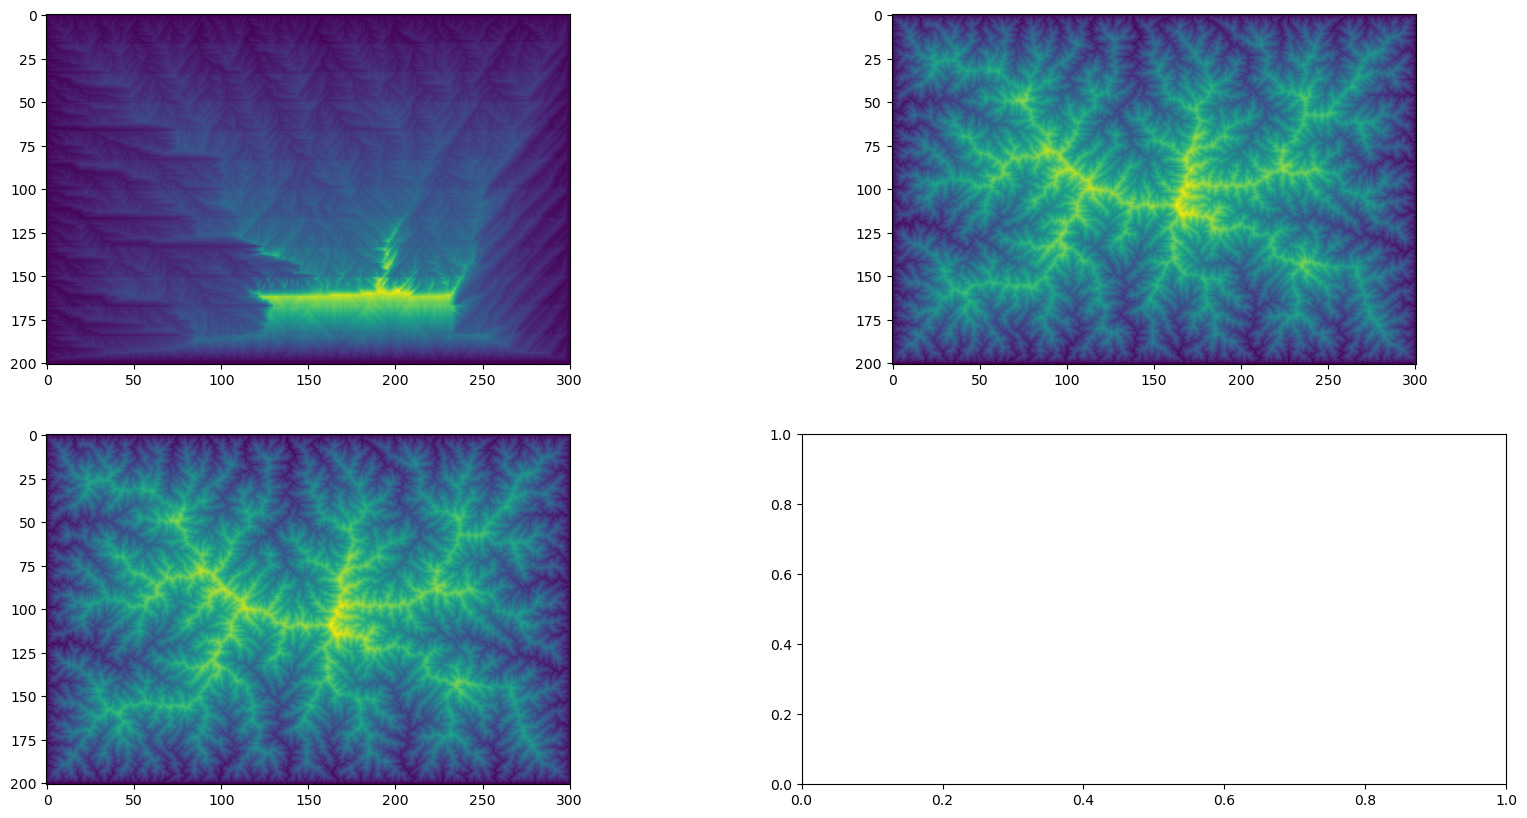

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axes[0, 0].imshow(run_simulation().reshape(grid.shape))
axes[0, 1].imshow(py_run_simulation().reshape(grid.shape))
axes[1, 0].imshow(run_simulation2());